In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader, Dataset, Sampler
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from tqdm.notebook import tqdm
import matplotlib
import torch
import torch.utils.data
from torchvision import datasets, transforms

device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

torch.set_float32_matmul_precision('high')

In [2]:
import torch

def print_device_info(device):
    # Normalize to torch.device
    device = torch.device(device)

    print(f"Requested device: {device}")
    print(f"CUDA available:  {torch.cuda.is_available()}")
    print(f"CUDA devices:    {torch.cuda.device_count()}")

    if torch.cuda.is_available():
        print(f"PyTorch CUDA:    {torch.version.cuda}")
        print(f"cuDNN:           {torch.backends.cudnn.version()}")

        # List all visible GPUs
        for i in range(torch.cuda.device_count()):
            props = torch.cuda.get_device_properties(i)
            total_gb = props.total_memory / (1024**3)
            print(f"[{i}] {props.name} | {total_gb:.1f} GiB | CC {props.major}.{props.minor}")

        # Place a tiny tensor on your requested device to confirm
        try:
            x = torch.empty(1, device=device)
            print(f"Tensor actually on: {x.device}")
        except Exception as e:
            print(f"Could not place tensor on {device}: {e}")

    else:
        # CPU/MPS fallback info
        if torch.backends.mps.is_available():
            print("MPS available (Apple Silicon).")
        print("Running on CPU.")

# >>> call it with whatever you set earlier <<<
print_device_info(device)   # e.g., device = torch.device('cuda:2')


Requested device: cuda:3
CUDA available:  True
CUDA devices:    4
PyTorch CUDA:    12.6
cuDNN:           90501
[0] NVIDIA GeForce GTX TITAN X | 11.9 GiB | CC 5.2
[1] NVIDIA GeForce GTX TITAN X | 11.9 GiB | CC 5.2
[2] NVIDIA GeForce GTX TITAN X | 11.9 GiB | CC 5.2
[3] NVIDIA GeForce GTX TITAN X | 11.9 GiB | CC 5.2
Tensor actually on: cuda:3


In [3]:
import numpy as np

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


# set the learning parameters
batch_size = 256

grid_images = []  # for visualizations

# Load metadata and data
data_path = "generated_data/first_20000_processed_data.npy"
shape_path = data_path.replace('.npy', '_shape.npy')
metadata_path = data_path.replace('.npy', '_injection_metadata.npy')
signals_only_path = data_path.replace('.npy', '_signals_only.npy')
shape = tuple(np.load(shape_path).astype(int))
data = np.memmap(data_path, dtype='float32', mode='r', shape=shape)
signals_only = np.memmap(signals_only_path, dtype='float32', mode='r', shape=shape)
metadata = np.load(metadata_path, allow_pickle=True)

def prepare_labels(labels):
    expanded_labels = []
    True_count_1 = True_count_2 = False_count_1 = False_count_2 = 0
    num_background = num_linear = 0

    for idx, ((injection_type, cadence_label), frame_flags) in tqdm(enumerate(labels), desc="Preparing labels", total=len(labels)):
        for frame_idx, frame_flag in enumerate(frame_flags):
            expanded_labels.append((injection_type, cadence_label, frame_flag, (idx, frame_idx)))

    return np.array(expanded_labels, dtype=object)

X_labels = prepare_labels(metadata)

print("Data Prepared")


Preparing labels:   0%|          | 0/20000 [00:00<?, ?it/s]

Data Prepared


In [4]:
# Build boolean masks first (element-wise):
# mask_training = (X_labels[:, 2] == "Background") | (X_labels[:, 2] == "Linear")
mask_training = (X_labels[:, 2] == "Linear")
# background_labels = (X_labels[:, 2] == "Background")
mask_non_training = ~mask_training
# mask_non_training = mask_non_training & ~background_labels

# Turn masks into index arrays (np.where returns a tuple)
training_indicies = np.where(mask_training)[0]
non_training_indicies = np.where(mask_non_training)[0]

X_labels_training = X_labels[training_indicies]
X_labels_non_training = X_labels[non_training_indicies]
# Split data
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

#split the training from the non dragons as dont want to train on dragons
print("First split")

#Split for Training Data
X_train_idx, X_temp_idx, y_train, y_temp = train_test_split(
                                                        np.arange(len(X_labels_training)), 
                                                        X_labels_training, 
                                                        test_size=1-train_ratio, 
                                                        random_state=42, 
                                                        stratify=X_labels_training[:, 2]
                                                        )

#Split the leftover from training data
print("Second split")
X_val_idx, X_test_only_linear, y_val, y_test_only_linear = train_test_split(
                                                        X_temp_idx, 
                                                        y_temp, 
                                                        test_size=0.4,   # have a few more go to validation set as WD and Sinusoids left out of Val 
                                                        random_state=42, 
                                                        stratify=y_temp[:, 2]
                                                        )

#combine the val and temp randomly
y_test = np.concatenate((y_test_only_linear, X_labels_non_training), axis=0)


First split
Second split


In [5]:
print(f"{np.unique(y_train[:,2])} for training")
print(f"{np.unique(y_val[:,2])} for validation")
print(f"{np.unique(y_test[:,2])} for testing") 

from collections import Counter

# Extract the second index from each label tuple (cadence_label)
cadence_labels = [label[2] for label in X_labels]

# Count occurrences of each unique label
label_counts = Counter(cadence_labels)

# Print nicely
for label, count in label_counts.items():
    print(f"Cadence Label '{label}': {count} samples")

['Linear'] for training
['Linear'] for validation
['Background' 'Linear' 'Sinusoid' 'Welsh_dragon'] for testing
Cadence Label 'Linear': 73920 samples
Cadence Label 'Background': 38688 samples
Cadence Label 'Welsh_dragon': 3696 samples
Cadence Label 'Sinusoid': 3696 samples


In [6]:
class MemmapFrameDataset(Dataset):
    def __init__(self, noisy_data, signals_only, labels):
        self.noisy_data   = noisy_data    # (N, 6, 16, 4096)
        self.signals_only = signals_only  # (N, 6, 16, 4096)
        self.labels       = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        inj_type, cadence_label, frame_flag, (cad_idx, frame_idx) = self.labels[idx]

        # Make a writable, C-contiguous float32 copy
        noisy_np   = np.array(self.noisy_data[cad_idx, frame_idx],   dtype=np.float32, copy=True, order="C")
        signal_np  = np.array(self.signals_only[cad_idx, frame_idx], dtype=np.float32, copy=True, order="C")

        noisy_t    = torch.from_numpy(noisy_np).unsqueeze(0)   # (1, 16, 4096)
        signal_t   = torch.from_numpy(signal_np).unsqueeze(0)  # (1, 16, 4096)

        return noisy_t, signal_t, frame_flag


In [7]:
# # --- put these near the very top of your notebook/script (BEFORE creating DataLoaders) ---
# import torch.multiprocessing as mp
# torch.backends.cudnn.benchmark = True             # faster convs for fixed shapes
# mp.set_sharing_strategy("file_system")            # avoid /dev/shm bottleneck
# ctx = mp.get_context("fork")                      # faster, memory-friendly workers
# # -----------------------------------------------------------------------------------------


In [8]:
train_dataset = MemmapFrameDataset(noisy_data=data, signals_only=signals_only, labels=y_train)
val_dataset   = MemmapFrameDataset(noisy_data=data, signals_only=signals_only, labels=y_val)
test_dataset  = MemmapFrameDataset(noisy_data=data, signals_only=signals_only, labels=y_test)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                         num_workers=20, pin_memory=True, persistent_workers=True, prefetch_factor=10)
valloader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=2, pin_memory=True, persistent_workers=True, prefetch_factor=2)
testloader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=2, pin_memory=True, persistent_workers=True, prefetch_factor=2)


In [9]:
# xb, yb, fb = next(iter(trainloader))
# print("batch shapes:", xb.shape, yb.shape)   # expect (B, 1, 16, 4096)

Training

In [10]:
# torch.backends.cudnn.benchmark = True  # speed for fixed input sizes
# from torch.cuda.amp import autocast, GradScaler
# scaler = GradScaler(enabled=use_amp)

In [11]:
def train(epoch, model, train_loader, optimizer, criterion, device):
    """
    Simple training loop with tqdm.
    Expects batches: (noisy, signals_only, frame_flag).
    NOTE: `use_amp` is accepted for call compatibility but unused here.
    """
    model.train()
    running_loss, seen = 0.0, 0
    total = len(train_loader.dataset)

    pbar = tqdm(train_loader, desc=f"train {epoch:02d}", unit="batch", leave=True)
    for batch_idx, (noisy, signals_only, _) in enumerate(pbar):
        noisy        = noisy.to(device, non_blocking=True)      # (B, 1, 16, 4096)
        signals_only = signals_only.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        recon = model(noisy)
        loss  = criterion(recon, signals_only)
        loss.backward()
        optimizer.step()

        bs = noisy.size(0)
        running_loss += loss.item() * bs
        seen += bs
        pbar.set_postfix(avg=f"{running_loss/max(1,seen):.6f}")

    return running_loss / max(1, total)


def validate(epoch, model, valloader, criterion, device):
    """
    Simple validation loop with tqdm.
    Expects batches: (noisy, signals_only, frame_flag).
    """
    model.eval()
    running_loss, seen = 0.0, 0
    total = len(valloader.dataset)

    pbar = tqdm(valloader, desc=f"val   {epoch:02d}", unit="batch", leave=True)
    with torch.no_grad():
        for batch_idx, (noisy, signals_only, _) in enumerate(pbar):
            noisy        = noisy.to(device, non_blocking=True)
            signals_only = signals_only.to(device, non_blocking=True)

            recon = model(noisy)
            loss  = criterion(recon, signals_only)

            bs = noisy.size(0)
            running_loss += loss.item() * bs
            seen += bs

            # show running avg on the bar
            pbar.set_postfix(avg=f"{running_loss/max(1,seen):.6f}")

    return running_loss / max(1, total)



In [12]:

# class ConvDAE(nn.Module):
#     """
#     Denoising Autoencoder for (B, 1, 16, 4096):
#       Encoder: Conv2d blocks with stride (1,4) along width to shrink 4096 → 1024 → 256 → 64
#       Bottleneck: Linear → latent_dim → Linear
#       Decoder: ConvTranspose2d blocks to grow 64 → 256 → 1024 → 4096 (exact sizes)
#     """
#     def __init__(self, latent_dim: int = 8, in_channels: int = 1, H: int = 16, W: int = 4096):
#         super().__init__()
#         self.latent_dim = latent_dim
#         self.in_channels = in_channels

#         # --- Encoder conv stack ---
#         # keep H by using stride=1 on height, downsample only width with stride=4
#         self.encoder_conv = nn.Sequential(
#             nn.Conv2d(in_channels, 16, kernel_size=(3, 7), stride=(1, 4), padding=(1, 3)),
#             nn.ReLU(inplace=True),

#             nn.Conv2d(16, 32, kernel_size=(3, 7), stride=(1, 4), padding=(1, 3)),
#             nn.ReLU(inplace=True),

#             nn.Conv2d(32, 64, kernel_size=(3, 7), stride=(1, 4), padding=(1, 3)),
#             nn.ReLU(inplace=True),
#         )

#         # figure out the encoder output shape to build the Linear layers
#         with torch.no_grad():
#             dummy = torch.zeros(1, in_channels, H, W)
#             enc = self.encoder_conv(dummy)          # -> (1, C_e=64, H_e=16, W_e=64)
#         Ce, He, We = enc.shape[1], enc.shape[2], enc.shape[3]
#         self._enc_shape = (Ce, He, We)
#         self._enc_flat  = Ce * He * We

#         # --- Bottleneck ---
#         self.fc_enc = nn.Sequential(
#             nn.Linear(self._enc_flat, 256),
#             nn.ReLU(inplace=True),
#             # nn.Linear(256, 128),
#             # nn.ReLU(inplace=True),
#             # nn.Linear(128, 64),
#             # nn.ReLU(inplace=True),
#             nn.Linear(256, latent_dim),
#         )
#         self.fc_dec = nn.Sequential(
#             nn.Linear(latent_dim, 256),
#             nn.ReLU(inplace=True),
#             # nn.Linear(64, 128),
#             # nn.ReLU(inplace=True),
#             # nn.Linear(128, 256),
#             nn.Linear(256, self._enc_flat),
#             nn.ReLU(inplace=True),
#         )

#         # --- Decoder deconv stack ---
#         # we invert the three width-downsamplings with stride=(1,4)
#         # output_padding=(0,3) ensures exact width reconstruction (…→64→256→1024→4096)
#         self.decoder_deconv = nn.Sequential(
#             nn.ConvTranspose2d(64, 32, kernel_size=(3, 7), stride=(1, 4),
#                                padding=(1, 3), output_padding=(0, 3)),
#             nn.ReLU(inplace=True),

#             nn.ConvTranspose2d(32, 16, kernel_size=(3, 7), stride=(1, 4),
#                                padding=(1, 3), output_padding=(0, 3)),
#             nn.ReLU(inplace=True),

#             nn.ConvTranspose2d(16, in_channels, kernel_size=(3, 7), stride=(1, 4),
#                                padding=(1, 3), output_padding=(0, 3)),
#             nn.Sigmoid(),  # inputs are per-frame max-normalized to [0,1]
#         )

#     # --------- logical API like your reference ---------
#     def encode(self, x: torch.Tensor) -> torch.Tensor:
#         """
#         x: (B,1,16,4096) → z: (B, latent_dim)
#         """
#         h = self.encoder_conv(x)           # (B,64,16,64)
#         h = h.flatten(1)                   # (B, 64*16*64)
#         z = self.fc_enc(h)                 # (B, latent_dim)
#         return z

#     def decode(self, z: torch.Tensor) -> torch.Tensor:
#         """
#         z: (B, latent_dim) → x̂: (B,1,16,4096)
#         """
#         h = self.fc_dec(z)                         # (B, 64*16*64)
#         h = h.view(-1, *self._enc_shape)          # (B,64,16,64)
#         x_hat = self.decoder_deconv(h)            # (B,1,16,4096)
#         return x_hat

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         """
#         x: (B,1,16,4096) → x̂: (B,1,16,4096)
#         """
#         z = self.encode(x)
#         x_hat = self.decode(z)
#         return x_hat


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvDAE(nn.Module):
    """
    Plain denoising autoencoder with the SAME conv/deconv structure
    as your FrameConvVAE, but:
      - deterministic bottleneck (no mu/logvar, no sampling)
      - encode: conv stack → flatten → MLP → z (latent_dim)
      - decode: z → MLP → feature map → deconv stack → output

    Input/Output: (B, 1, 16, 4096)
    """
    def __init__(self, image_channels: int = 1, latent_dim: int = 16,
                 out_activation: str = "sigmoid"):
        super().__init__()
        self.latent_dim = latent_dim

        # ─── Encoder conv blocks (identical to your VAE) ───
        self.enc1 = nn.Conv2d(image_channels,  16, kernel_size=3, stride=2, padding=1)  # → [B,16, 8,2048]
        self.bn1  = nn.BatchNorm2d(16)
        self.enc2 = nn.Conv2d(16,             16, kernel_size=3, stride=1, padding=1)  # → [B,16, 8,2048]
        self.bn2  = nn.BatchNorm2d(16)

        self.enc3 = nn.Conv2d(16,             32, kernel_size=3, stride=2, padding=1)  # → [B,32, 4,1024]
        self.bn3  = nn.BatchNorm2d(32)
        self.enc4 = nn.Conv2d(32,             32, kernel_size=3, stride=1, padding=1)  # → [B,32, 4,1024]
        self.bn4  = nn.BatchNorm2d(32)

        self.enc5 = nn.Conv2d(32,             64, kernel_size=3, stride=2, padding=1)  # → [B,64, 2, 512]
        self.bn5  = nn.BatchNorm2d(64)
        self.enc6 = nn.Conv2d(64,             64, kernel_size=3, stride=1, padding=1)  # → [B,64, 2, 512]
        self.bn6  = nn.BatchNorm2d(64)

        self.enc7 = nn.Conv2d(64,            128, kernel_size=3, stride=2, padding=1)  # → [B,128,1, 256]
        self.bn7  = nn.BatchNorm2d(128)
        self.enc8 = nn.Conv2d(128,           128, kernel_size=3, stride=1, padding=1)  # → [B,128,1, 256]
        self.bn8  = nn.BatchNorm2d(128)

        # flattened size = 128 × 1 × 256
        self.flatten_dim = 128 * 1 * 256

        # ─── Deterministic bottleneck (no mu/logvar) ───
        self.fc_enc1   = nn.Linear(self.flatten_dim, 512)
        self.bn_enc1   = nn.BatchNorm1d(512)
        self.fc_latent = nn.Linear(512, latent_dim)

        self.fc_dec1   = nn.Linear(latent_dim, 512)
        self.bn_dec1   = nn.BatchNorm1d(512)
        self.fc_dec2   = nn.Linear(512, self.flatten_dim)
        self.bn_dec2   = nn.BatchNorm1d(self.flatten_dim)

        # ─── Decoder deconv blocks (mirror of encoder) ───
        self.dec1 = nn.ConvTranspose2d(128,  64, kernel_size=3, stride=2, padding=1, output_padding=1)  # → [B,64, 2,512]
        self.bn_d1 = nn.BatchNorm2d(64)
        self.dec2 = nn.ConvTranspose2d(64,   64, kernel_size=3, stride=1, padding=1)                    # → [B,64, 2,512]
        self.bn_d2 = nn.BatchNorm2d(64)

        self.dec3 = nn.ConvTranspose2d(64,   32, kernel_size=3, stride=2, padding=1, output_padding=1)  # → [B,32, 4,1024]
        self.bn_d3 = nn.BatchNorm2d(32)
        self.dec4 = nn.ConvTranspose2d(32,   32, kernel_size=3, stride=1, padding=1)                    # → [B,32, 4,1024]
        self.bn_d4 = nn.BatchNorm2d(32)

        self.dec5 = nn.ConvTranspose2d(32,   16, kernel_size=3, stride=2, padding=1, output_padding=1)  # → [B,16, 8,2048]
        self.bn_d5 = nn.BatchNorm2d(16)
        self.dec6 = nn.ConvTranspose2d(16,   16, kernel_size=3, stride=1, padding=1)                    # → [B,16, 8,2048]
        self.bn_d6 = nn.BatchNorm2d(16)

        self.dec7 = nn.ConvTranspose2d(16,    1, kernel_size=3, stride=2, padding=1, output_padding=1)  # → [B,1,16,4096]

        # output activation (keep "sigmoid" for 0–1 targets, or use "softplus"/"identity")
        act = out_activation.lower()
        if act == "identity":
            self.out_act = nn.Identity()
        elif act == "softplus":
            self.out_act = nn.Softplus(beta=1.0)
        else:
            self.out_act = nn.Sigmoid()

    # --------- same API shape as your VAE (minus mu/logvar) ---------
    def encode(self, x):
        x = F.relu(self.bn1(self.enc1(x)), inplace=True)
        x = F.relu(self.bn2(self.enc2(x)), inplace=True)
        x = F.relu(self.bn3(self.enc3(x)), inplace=True)
        x = F.relu(self.bn4(self.enc4(x)), inplace=True)
        x = F.relu(self.bn5(self.enc5(x)), inplace=True)
        x = F.relu(self.bn6(self.enc6(x)), inplace=True)
        x = F.relu(self.bn7(self.enc7(x)), inplace=True)
        x = F.relu(self.bn8(self.enc8(x)), inplace=True)
        x = x.view(x.size(0), -1)

        h = F.relu(self.bn_enc1(self.fc_enc1(x)), inplace=True)
        z = self.fc_latent(h)
        return z

    def decode(self, z):
        h = F.relu(self.bn_dec1(self.fc_dec1(z)), inplace=True)
        h = F.relu(self.bn_dec2(self.fc_dec2(h)), inplace=True)
        h = h.view(-1, 128, 1, 256)

        h = F.relu(self.bn_d1(self.dec1(h)), inplace=True)
        h = F.relu(self.bn_d2(self.dec2(h)), inplace=True)
        h = F.relu(self.bn_d3(self.dec3(h)), inplace=True)
        h = F.relu(self.bn_d4(self.dec4(h)), inplace=True)
        h = F.relu(self.bn_d5(self.dec5(h)), inplace=True)
        h = F.relu(self.bn_d6(self.dec6(h)), inplace=True)
        logits = self.dec7(h)
        return self.out_act(logits)

    def forward(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat


Training

In [23]:
latent_dim = 8  # tweak as you like
lr = 0.0005
epochs = 30

model = ConvDAE(latent_dim=latent_dim).to(device)
criterion = nn.MSELoss()                   # or nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)  # you set lr earlier


In [24]:
train_losses, val_losses = [], []
# epochs = 12
epoch_bar = tqdm(range(1, epochs + 1), desc="Epochs", unit="ep")
for epoch in epoch_bar:
    tr_loss = train(epoch, model, trainloader, optimizer, criterion, device)
    print(f"Epoch {epoch:02d} train loss: {tr_loss:.4f}")
    va_loss = validate(epoch, model, valloader, criterion, device)
    print(f"Epoch {epoch:02d} val loss:   {va_loss:.4f}")
    train_losses.append(tr_loss)
    val_losses.append(va_loss)

    # live progress summary
    epoch_bar.set_postfix(train=f"{tr_loss:.4f}", val=f"{va_loss:.4f}")



Epochs:   0%|          | 0/30 [00:00<?, ?ep/s]

train 01:   0%|          | 0/231 [00:00<?, ?batch/s]

Epoch 01 train loss: 0.0607


val   01:   0%|          | 0/35 [00:00<?, ?batch/s]

Epoch 01 val loss:   0.0210


train 02:   0%|          | 0/231 [00:00<?, ?batch/s]

Epoch 02 train loss: 0.0122


val   02:   0%|          | 0/35 [00:00<?, ?batch/s]

Epoch 02 val loss:   0.0071


train 03:   0%|          | 0/231 [00:00<?, ?batch/s]

Epoch 03 train loss: 0.0047


val   03:   0%|          | 0/35 [00:00<?, ?batch/s]

Epoch 03 val loss:   0.0031


train 04:   0%|          | 0/231 [00:00<?, ?batch/s]

Epoch 04 train loss: 0.0025


val   04:   0%|          | 0/35 [00:00<?, ?batch/s]

Epoch 04 val loss:   0.0019


train 05:   0%|          | 0/231 [00:00<?, ?batch/s]

Epoch 05 train loss: 0.0017


val   05:   0%|          | 0/35 [00:00<?, ?batch/s]

Epoch 05 val loss:   0.0013


train 06:   0%|          | 0/231 [00:00<?, ?batch/s]

Epoch 06 train loss: 0.0013


val   06:   0%|          | 0/35 [00:00<?, ?batch/s]

Epoch 06 val loss:   0.0011


train 07:   0%|          | 0/231 [00:00<?, ?batch/s]

Epoch 07 train loss: 0.0010


val   07:   0%|          | 0/35 [00:00<?, ?batch/s]

Epoch 07 val loss:   0.0009


train 08:   0%|          | 0/231 [00:00<?, ?batch/s]

Epoch 08 train loss: 0.0009


val   08:   0%|          | 0/35 [00:00<?, ?batch/s]

Epoch 08 val loss:   0.0007


train 09:   0%|          | 0/231 [00:00<?, ?batch/s]

Epoch 09 train loss: 0.0008


val   09:   0%|          | 0/35 [00:00<?, ?batch/s]

Epoch 09 val loss:   0.0006


train 10:   0%|          | 0/231 [00:00<?, ?batch/s]

Epoch 10 train loss: 0.0007


val   10:   0%|          | 0/35 [00:00<?, ?batch/s]

Epoch 10 val loss:   0.0005


train 11:   0%|          | 0/231 [00:00<?, ?batch/s]

Epoch 11 train loss: 0.0006


val   11:   0%|          | 0/35 [00:00<?, ?batch/s]

Epoch 11 val loss:   0.0005


train 12:   0%|          | 0/231 [00:00<?, ?batch/s]

Epoch 12 train loss: 0.0006


val   12:   0%|          | 0/35 [00:00<?, ?batch/s]

Epoch 12 val loss:   0.0005


train 13:   0%|          | 0/231 [00:00<?, ?batch/s]

Epoch 13 train loss: 0.0006


val   13:   0%|          | 0/35 [00:00<?, ?batch/s]

Epoch 13 val loss:   0.0004


train 14:   0%|          | 0/231 [00:00<?, ?batch/s]

Epoch 14 train loss: 0.0005


val   14:   0%|          | 0/35 [00:00<?, ?batch/s]

Epoch 14 val loss:   0.0004


train 15:   0%|          | 0/231 [00:00<?, ?batch/s]

Epoch 15 train loss: 0.0005


val   15:   0%|          | 0/35 [00:00<?, ?batch/s]

Epoch 15 val loss:   0.0004


train 16:   0%|          | 0/231 [00:00<?, ?batch/s]

Epoch 16 train loss: 0.0005


val   16:   0%|          | 0/35 [00:00<?, ?batch/s]

Epoch 16 val loss:   0.0004


train 17:   0%|          | 0/231 [00:00<?, ?batch/s]

Epoch 17 train loss: 0.0005


val   17:   0%|          | 0/35 [00:00<?, ?batch/s]

Epoch 17 val loss:   0.0003


train 18:   0%|          | 0/231 [00:00<?, ?batch/s]

Epoch 18 train loss: 0.0004


val   18:   0%|          | 0/35 [00:00<?, ?batch/s]

Epoch 18 val loss:   0.0003


train 19:   0%|          | 0/231 [00:00<?, ?batch/s]

Epoch 19 train loss: 0.0004


val   19:   0%|          | 0/35 [00:00<?, ?batch/s]

Epoch 19 val loss:   0.0003


train 20:   0%|          | 0/231 [00:00<?, ?batch/s]

Epoch 20 train loss: 0.0004


val   20:   0%|          | 0/35 [00:00<?, ?batch/s]

Epoch 20 val loss:   0.0003


train 21:   0%|          | 0/231 [00:00<?, ?batch/s]

Epoch 21 train loss: 0.0004


val   21:   0%|          | 0/35 [00:00<?, ?batch/s]

Epoch 21 val loss:   0.0004


train 22:   0%|          | 0/231 [00:00<?, ?batch/s]

Epoch 22 train loss: 0.0004


val   22:   0%|          | 0/35 [00:00<?, ?batch/s]

Epoch 22 val loss:   0.0003


train 23:   0%|          | 0/231 [00:00<?, ?batch/s]

Epoch 23 train loss: 0.0004


val   23:   0%|          | 0/35 [00:00<?, ?batch/s]

Epoch 23 val loss:   0.0003


train 24:   0%|          | 0/231 [00:00<?, ?batch/s]

Epoch 24 train loss: 0.0004


val   24:   0%|          | 0/35 [00:00<?, ?batch/s]

Epoch 24 val loss:   0.0003


train 25:   0%|          | 0/231 [00:00<?, ?batch/s]

Epoch 25 train loss: 0.0004


val   25:   0%|          | 0/35 [00:00<?, ?batch/s]

Epoch 25 val loss:   0.0003


train 26:   0%|          | 0/231 [00:00<?, ?batch/s]

Epoch 26 train loss: 0.0004


val   26:   0%|          | 0/35 [00:00<?, ?batch/s]

Epoch 26 val loss:   0.0003


train 27:   0%|          | 0/231 [00:00<?, ?batch/s]

Epoch 27 train loss: 0.0003


val   27:   0%|          | 0/35 [00:00<?, ?batch/s]

Epoch 27 val loss:   0.0003


train 28:   0%|          | 0/231 [00:00<?, ?batch/s]

Epoch 28 train loss: 0.0003


val   28:   0%|          | 0/35 [00:00<?, ?batch/s]

Epoch 28 val loss:   0.0002


train 29:   0%|          | 0/231 [00:00<?, ?batch/s]

Epoch 29 train loss: 0.0003


val   29:   0%|          | 0/35 [00:00<?, ?batch/s]

Epoch 29 val loss:   0.0002


train 30:   0%|          | 0/231 [00:00<?, ?batch/s]

Epoch 30 train loss: 0.0003


val   30:   0%|          | 0/35 [00:00<?, ?batch/s]

Epoch 30 val loss:   0.0002


In [25]:
def save_run_artifacts(model, optimizer, train_losses, val_losses, cfg: dict,
                       run_dir: str | None = None, save_curves: bool = True):
    """
    Save a complete snapshot of this training run into a unique folder.

    Args:
      model, optimizer: your PyTorch objects.
      train_losses, val_losses: lists of floats (one per epoch).
      cfg: dict of run metadata (hyperparams, sizes, device, etc.).
           e.g. {"model_name": "ConvDAE", "latent_dim": 8, "lr": 1e-3, ...}
      run_dir: optional custom output dir; if None, auto-create with timestamp.
      save_curves: also save a PNG of the train/val curves.
    Returns:
      str: path to the saved run directory.
    """
    import os, json, time
    import numpy as np
    import torch
    import matplotlib.pyplot as plt

    # make a unique folder for this run
    ts = time.strftime("%Y%m%d-%H%M%S")
    if run_dir is None:
        run_name = f"{cfg.get('model_name','DAE')}_lat{cfg.get('latent_dim','?')}_ep{cfg.get('epochs','?')}_{ts}"
        run_dir = os.path.join("checkpoints", run_name)
    os.makedirs(run_dir, exist_ok=True)

    # 1) weights-only (good for inference)
    weights_path = os.path.join(run_dir, "weights.pt")
    torch.save(model.state_dict(), weights_path)

    # 2) full checkpoint (resume training later)
    ckpt_path = os.path.join(run_dir, "checkpoint.pth")
    torch.save(
        {
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "train_losses": np.array(train_losses, dtype=np.float32),
            "val_losses": np.array(val_losses, dtype=np.float32),
            "cfg": cfg,
        },
        ckpt_path,
    )

    # 3) losses as .npy for quick reload
    np.save(os.path.join(run_dir, "train_losses.npy"), np.array(train_losses, dtype=np.float32))
    np.save(os.path.join(run_dir, "val_losses.npy"),   np.array(val_losses,   dtype=np.float32))

    # 4) config + model text
    with open(os.path.join(run_dir, "config.json"), "w") as f:
        json.dump(cfg, f, indent=2)
    with open(os.path.join(run_dir, "model.txt"), "w") as f:
        f.write(str(model))

    # 5) training curves
    if save_curves:
        plt.figure(figsize=(7,4))
        plt.plot(train_losses, label="train")
        plt.plot(val_losses,   label="val")
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.title("Training vs Validation Loss")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(run_dir, "curves.png"), dpi=150)
        plt.close()

    print(f"Saved run to: {run_dir}")
    print(f"  - weights:   {weights_path}")
    print(f"  - checkpoint:{ckpt_path}")
    return run_dir



In [26]:
cfg = {
    "model_name": model.__class__.__name__,
    "latent_dim": latent_dim,
    "lr": lr,
    "batch_size": batch_size,
    "epochs": epochs,
    "device": str(device),
    "train_size": len(train_dataset),
    "val_size": len(val_dataset),
    "test_size": len(test_dataset),
}

run_dir = save_run_artifacts(model, optimizer, train_losses, val_losses, cfg)


Saved run to: checkpoints/ConvDAE_lat8_ep30_20250824-120503
  - weights:   checkpoints/ConvDAE_lat8_ep30_20250824-120503/weights.pt
  - checkpoint:checkpoints/ConvDAE_lat8_ep30_20250824-120503/checkpoint.pth


In [19]:
import os, json, torch

# pick the run you want
run_dir = "checkpoints/With_B_20k_30E_ConvDAE_lat8_ep30_20250824-120503"  # <-- your folder

# read the config we saved (to get latent_dim, etc.)
with open(os.path.join(run_dir, "config.json"), "r") as f:
    cfg = json.load(f)

latent_dim = int(cfg["latent_dim"])

model = ConvDAE(latent_dim=latent_dim).to(device)

# load weights.pt
state = torch.load(os.path.join(run_dir, "weights.pt"), map_location=device)

# handle DataParallel saves if needed
if any(k.startswith("module.") for k in state.keys()):
    state = {k.replace("module.", "", 1): v for k, v in state.items()}

model.load_state_dict(state, strict=True)
model.eval()

# ckpt = torch.load(os.path.join(run_dir, "checkpoint.pth"), map_state_dict=False, map_location="cpu")
train_losses = np.load(os.path.join(run_dir, "train_losses.npy")).tolist()
val_losses   = np.load(os.path.join(run_dir, "val_losses.npy")).tolist()

# print(len(train_losses), len(val_losses))


print("Loaded weights for inference from:", run_dir)


Loaded weights for inference from: checkpoints/With_B_20k_30E_ConvDAE_lat8_ep30_20250824-120503


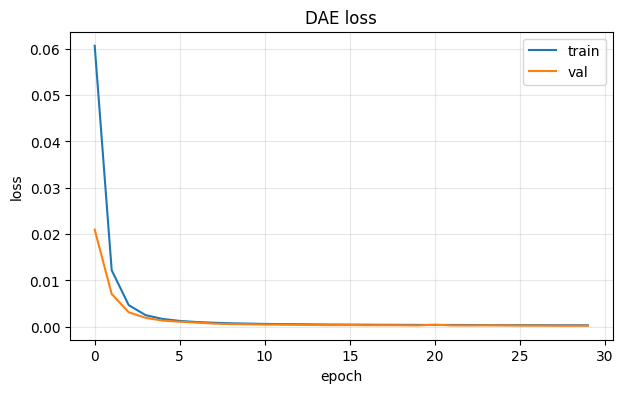

In [20]:

import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("DAE loss")
plt.grid(alpha=0.3); plt.legend()
plt.show()


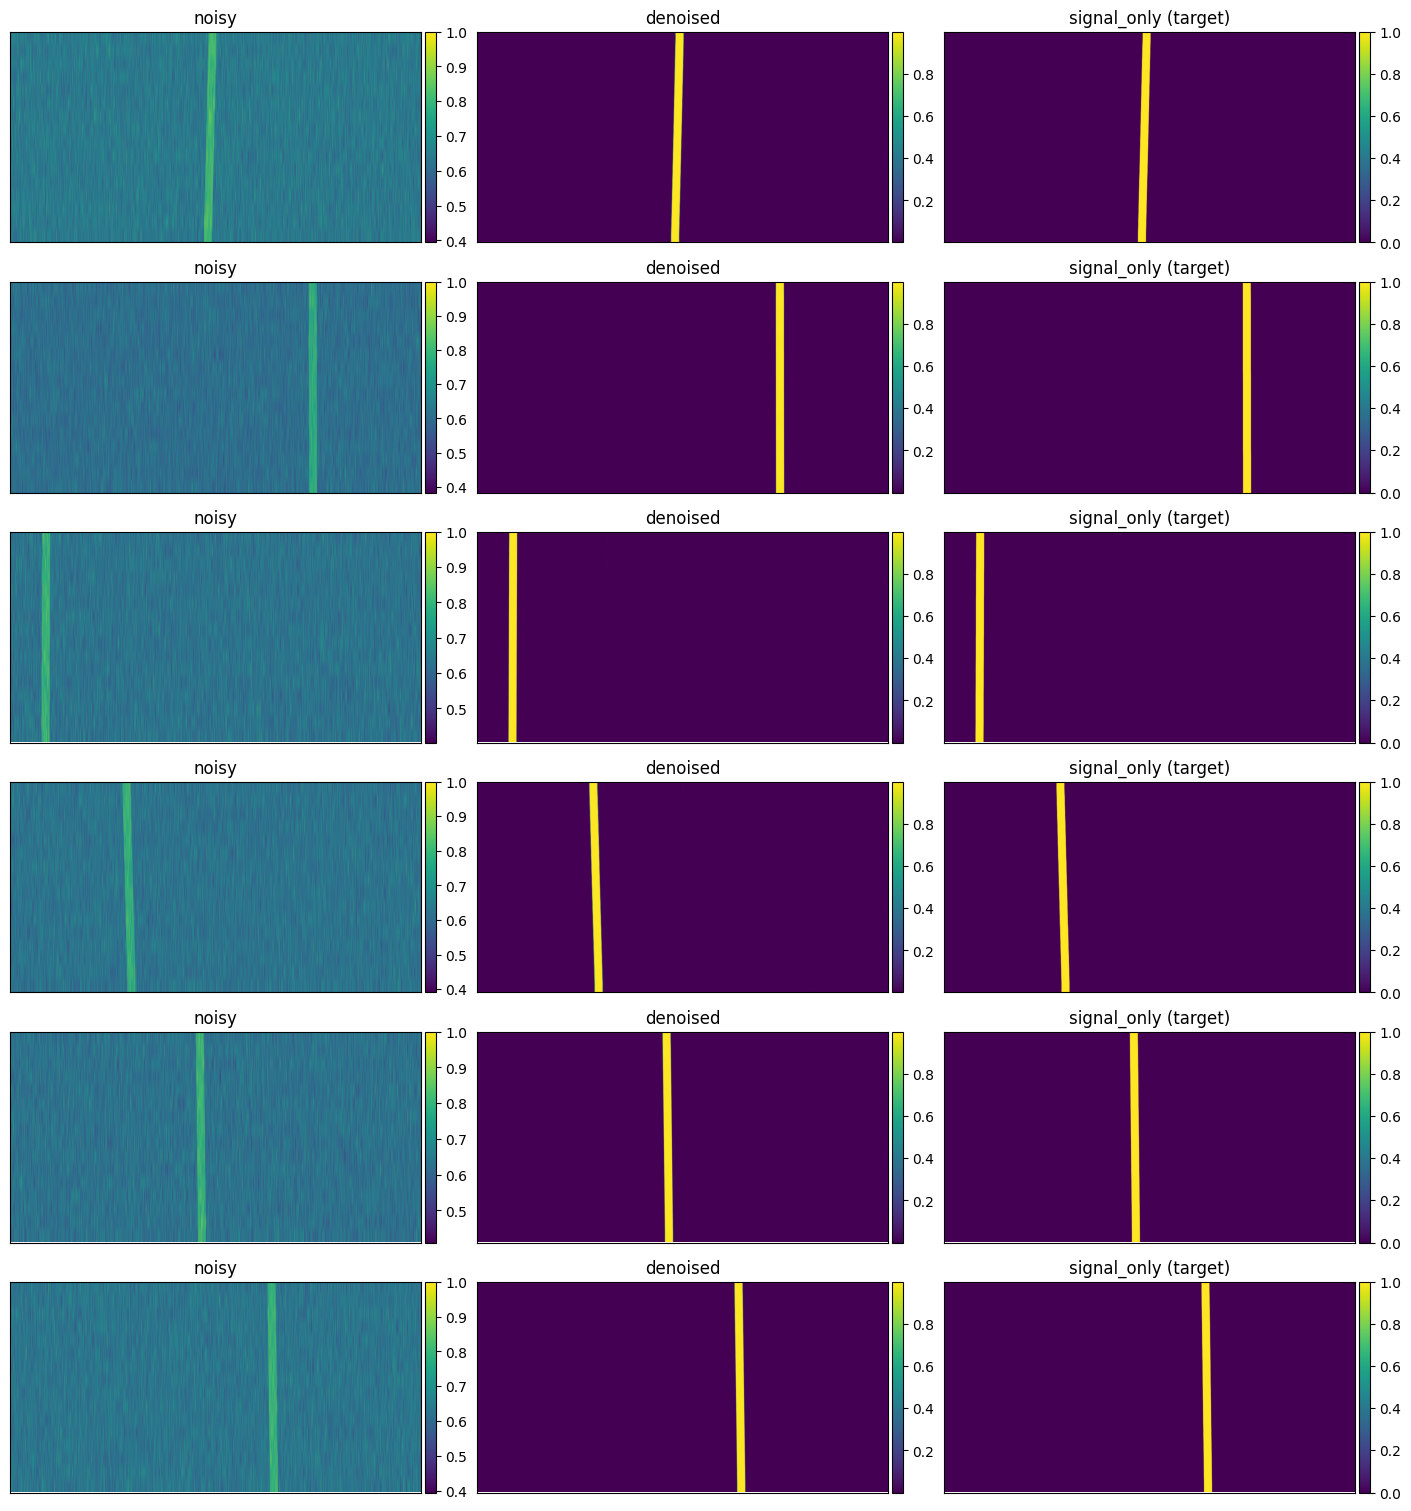

In [21]:
model.eval()
with torch.no_grad():
    noisy, sig_only, flags = next(iter(testloader))  # (B,1,16,4096), (B,1,16,4096)
    noisy = noisy.to(device, non_blocking=True)
    sig_only = sig_only.to(device, non_blocking=True)
    recon = model(noisy)  # (B,1,16,4096)

# show a few rows
Bshow = min(6, noisy.size(0))
fig, axes = plt.subplots(Bshow, 3, figsize=(14, 2.5*Bshow), constrained_layout=True)

for i in range(Bshow):
    # remove channel dim -> (16,4096)
    n = noisy[i, 0].detach().cpu().numpy()
    r = recon[i, 0].detach().cpu().numpy()
    g = sig_only[i, 0].detach().cpu().numpy()

    im0 = axes[i, 0].imshow(n, aspect='auto', cmap='viridis')
    axes[i, 0].set_title("noisy")
    im1 = axes[i, 1].imshow(r, aspect='auto', cmap='viridis')
    axes[i, 1].set_title("denoised")
    im2 = axes[i, 2].imshow(g, aspect='auto', cmap='viridis')
    axes[i, 2].set_title("signal_only (target)")

    for ax, im in zip(axes[i], [im0, im1, im2]):
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.01)
        ax.set_xticks([]); ax.set_yticks([])

plt.show()


In [22]:
import heapq


def collect_worst(loader, model, device, K=20, metric='l1'):
    """
    Scan a loader and keep the K worst items by per-sample reconstruction error.

    loader yields: (noisy, signal_only, frame_flag)
    model(noisy) -> recon, shape (B,1,16,4096)

    metric: 'l1' | 'l2' | 'bce'
    returns: list of (error, noisy[0], recon[0], target[0]) sorted desc by error
    """
    model.eval()
    heap = []  # min-heap of fixed size K

    with torch.no_grad():
        for noisy, target, _ in tqdm(loader, desc='Scanning', unit='batch'):
            noisy  = noisy.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)
            recon  = model(noisy)

            if metric == 'l1':
                per = (recon - target).abs().flatten(1).mean(1)
            elif metric == 'l2':
                per = F.mse_loss(recon, target, reduction='none').flatten(1).mean(1)
            elif metric == 'bce':
                per = F.binary_cross_entropy(
                    recon.clamp(1e-7, 1-1e-7),
                    target.clamp(0, 1),
                    reduction='none'
                ).flatten(1).mean(1)
            else:
                raise ValueError("metric must be one of: 'l1', 'l2', 'bce'")

            # move to CPU once per batch
            per_cpu = per.detach().cpu()
            n_cpu   = noisy.detach().cpu()
            r_cpu   = recon.detach().cpu()
            t_cpu   = target.detach().cpu()

            for i in range(per_cpu.shape[0]):
                # store channel-removed 2D arrays (16x4096)
                entry = (per_cpu[i].item(), n_cpu[i, 0], r_cpu[i, 0], t_cpu[i, 0])
                if len(heap) < K:
                    heapq.heappush(heap, entry)
                else:
                    if entry[0] > heap[0][0]:
                        heapq.heapreplace(heap, entry)

    return sorted(heap, key=lambda x: x[0], reverse=True)


def plot_triplets(items, title=''):
    """
    items: list of (err, noisy_2d, recon_2d, target_2d)
    Plots rows = len(items), cols = 3 with colorbars.
    """
    rows = len(items)
    fig, axes = plt.subplots(rows, 3, figsize=(14, 2.5*rows), constrained_layout=True)
    if rows == 1:
        axes = axes[None, :]  # make it 2D for consistent indexing

    for i, (err, n, r, t) in enumerate(items):
        im0 = axes[i, 0].imshow(n.numpy(), aspect='auto', cmap='viridis')
        axes[i, 0].set_title("noisy")

        im1 = axes[i, 1].imshow(r.numpy(), aspect='auto', cmap='viridis')
        axes[i, 1].set_title(f"denoised\nerr={err:.4f}")

        im2 = axes[i, 2].imshow(t.numpy(), aspect='auto', cmap='viridis')
        axes[i, 2].set_title("signal_only (target)")

        for ax, im in zip(axes[i], [im0, im1, im2]):
            ax.set_xticks([]); ax.set_yticks([])
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.01)

    if title:
        fig.suptitle(title, fontsize=12)
    plt.show()


Scanning:   0%|          | 0/35 [00:00<?, ?batch/s]

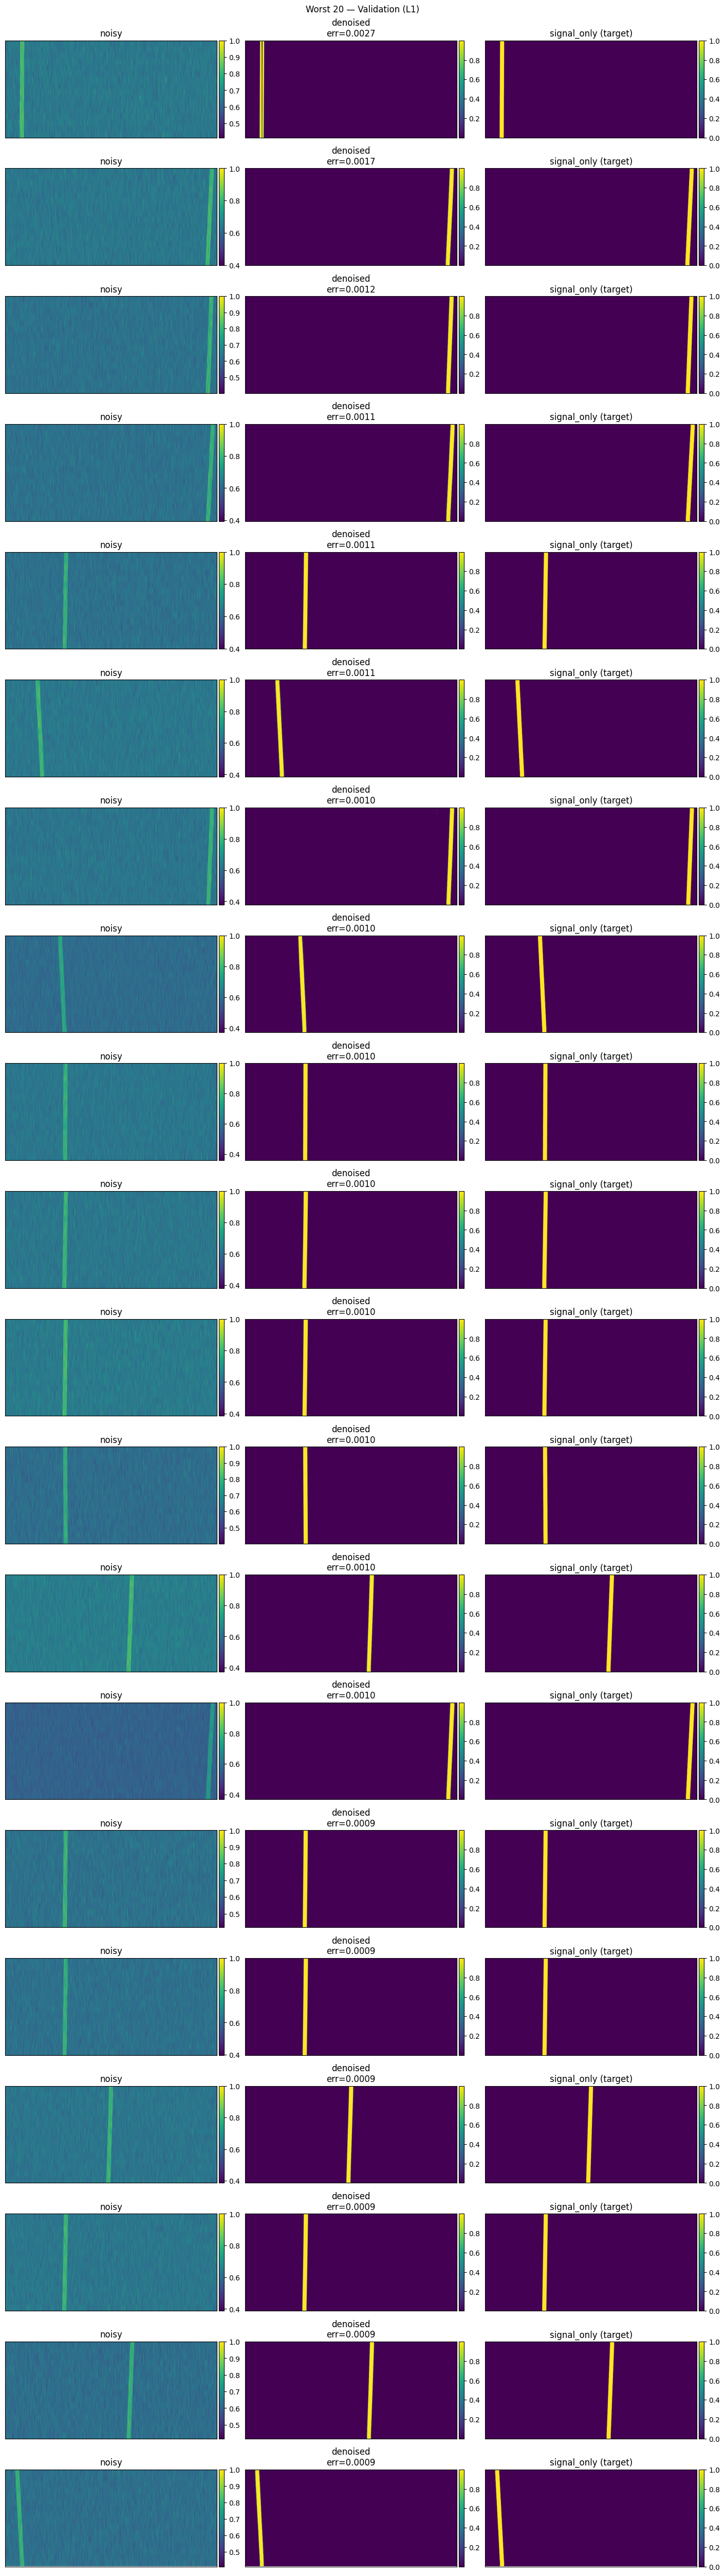

In [23]:
# pick your metric: 'l1' usually matches your training loss if you used L1Loss
worst_val = collect_worst(valloader, model, device, K=20, metric='l2')
plot_triplets(worst_val, title='Worst 20 — Validation (L1)')


In [24]:
worst_test = collect_worst(testloader, model, device, K=20, metric='l2')
plot_triplets(worst_test, title='Worst 20 — Test (L1)')


Scanning:   0%|          | 0/204 [00:00<?, ?batch/s]

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [25]:


def collect_errors_by_label(loader, model, device, metric='l1', desc='Scanning'):
    """
    Returns:
        errors_list (list[float]): per-sample error
        labels_list (list[str])  : matching frame_flag strings
    """
    model.eval()
    errors_list, labels_list = [], []

    with torch.no_grad():
        for noisy, target, frame_flags in tqdm(loader, desc=desc, unit='batch'):
            noisy  = noisy.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)
            recon  = model(noisy)

            if metric == 'l1':
                per = (recon - target).abs().flatten(1).mean(1)
            elif metric == 'l2':
                per = F.mse_loss(recon, target, reduction='none').flatten(1).mean(1)
            elif metric == 'bce':
                per = F.binary_cross_entropy(
                    recon.clamp(1e-7, 1-1e-7),
                    target.clamp(0, 1),
                    reduction='none'
                ).flatten(1).mean(1)
            else:
                raise ValueError("metric must be 'l1', 'l2', or 'bce'")

            # frame_flags is a list of strings (length B)
            errors_list.extend(per.detach().cpu().tolist())
            labels_list.extend(list(frame_flags))

    return errors_list, labels_list


In [26]:

# collect for validation & test (choose metric to match your training loss)
val_errors, val_labels   = collect_errors_by_label(valloader,  model, device, metric='l2', desc='Val errors')
test_errors, test_labels = collect_errors_by_label(testloader, model, device, metric='l2', desc='Test errors')

# ---------- plot (validation) ----------
errors_array = np.array(val_errors)
labels_array = np.array(val_labels)
unique_labels = np.unique(labels_array)
bins = np.linspace(errors_array.min(), errors_array.max(), 30)

plt.figure(figsize=(10, 6))
for lbl in unique_labels:
    mask = labels_array == lbl
    plt.hist(errors_array[mask],
             bins=bins,
             alpha=0.5,
             label=str(lbl),
             edgecolor='none',
             density=True)
plt.title("Validation Reconstruction Error by Label")
plt.xlabel("Reconstruction Error")
plt.ylabel("Density")
plt.legend(title="Label", loc='upper right')
plt.tight_layout()
plt.show()

# ---------- plot (test) ----------
errors_array = np.array(test_errors)
labels_array = np.array(test_labels)
unique_labels = np.unique(labels_array)
bins = np.linspace(errors_array.min(), errors_array.max(), 30)

plt.figure(figsize=(10, 6))
for lbl in unique_labels:
    mask = labels_array == lbl
    plt.hist(errors_array[mask],
             bins=bins,
             alpha=0.5,
             label=str(lbl),
             edgecolor='none',
             density=True)
plt.title("Test Reconstruction Error by Label")
plt.xlabel("Reconstruction Error")
plt.ylabel("Density")
plt.legend(title="Label", loc='upper right')
plt.tight_layout()
plt.show()


Val errors:   0%|          | 0/35 [00:00<?, ?batch/s]

Test errors:   0%|          | 0/204 [00:00<?, ?batch/s]

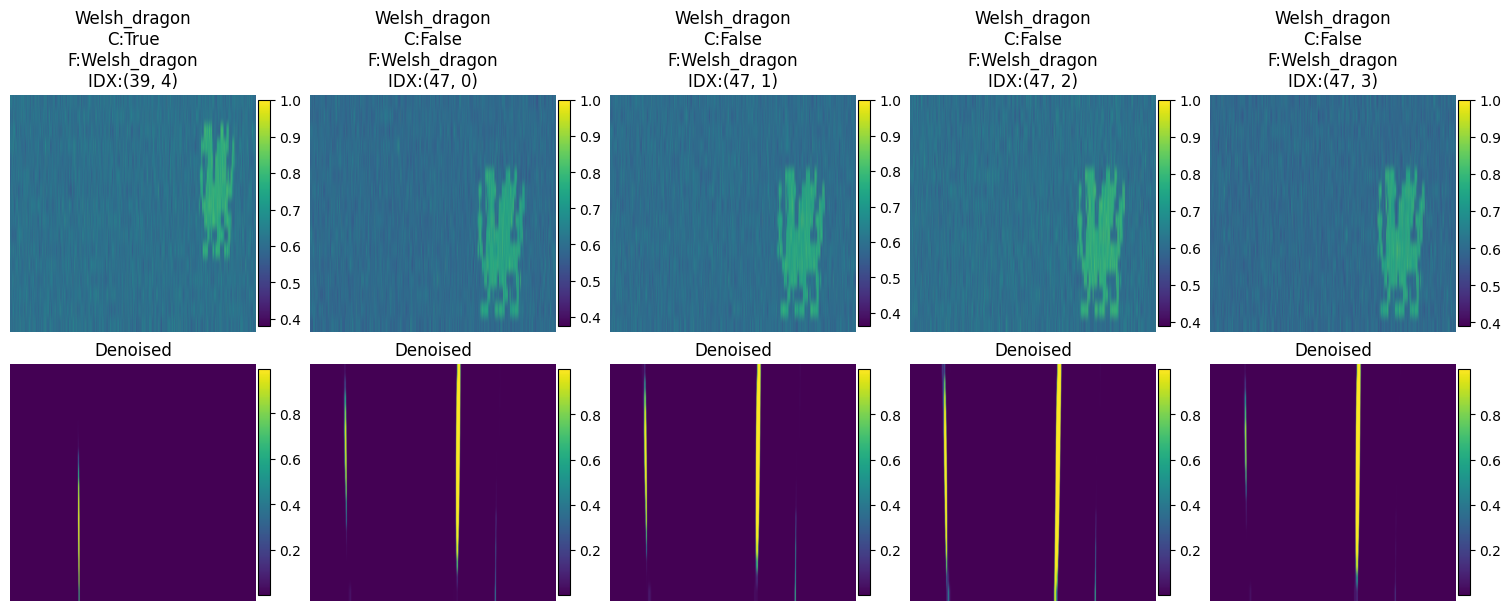

In [ ]:
# Pick first N Welsh_dragon samples from the *test* set and visualize
num_images = 5
indices_to_show = np.where(y_test[:, 2] == "Welsh_dragon")[0].tolist()
indices_to_show = indices_to_show[5:5 + num_images]  # skip first few, take next num_images

# Stack the *noisy* frames from the dataset
sample_data  = torch.stack([test_dataset[i][0] for i in indices_to_show]).to(device, non_blocking=True)
sample_labels = [y_test[i] for i in indices_to_show]

model.eval()
with torch.no_grad():
    reconstructed = model(sample_data)  # DAE: just the reconstruction

# Plot
fig, axes = plt.subplots(2, num_images, figsize=(3 * num_images, 6), constrained_layout=True)
for col, i_ds in enumerate(indices_to_show):
    inj_type, cadence_label, frame_flag, orig_idx = sample_labels[col]

    ax0 = axes[0, col]
    im0 = ax0.imshow(sample_data[col, 0].detach().cpu().numpy(), aspect='auto', cmap='viridis')
    ax0.set_title(f"{inj_type}\nC:{cadence_label}\nF:{frame_flag}\nIDX:{orig_idx}")
    ax0.axis("off")
    plt.colorbar(im0, ax=ax0, fraction=0.046, pad=0.01)

    ax1 = axes[1, col]
    im1 = ax1.imshow(reconstructed[col, 0].detach().cpu().numpy(), aspect='auto', cmap='viridis')
    ax1.set_title("Denoised")
    ax1.axis("off")
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.01)

plt.show()


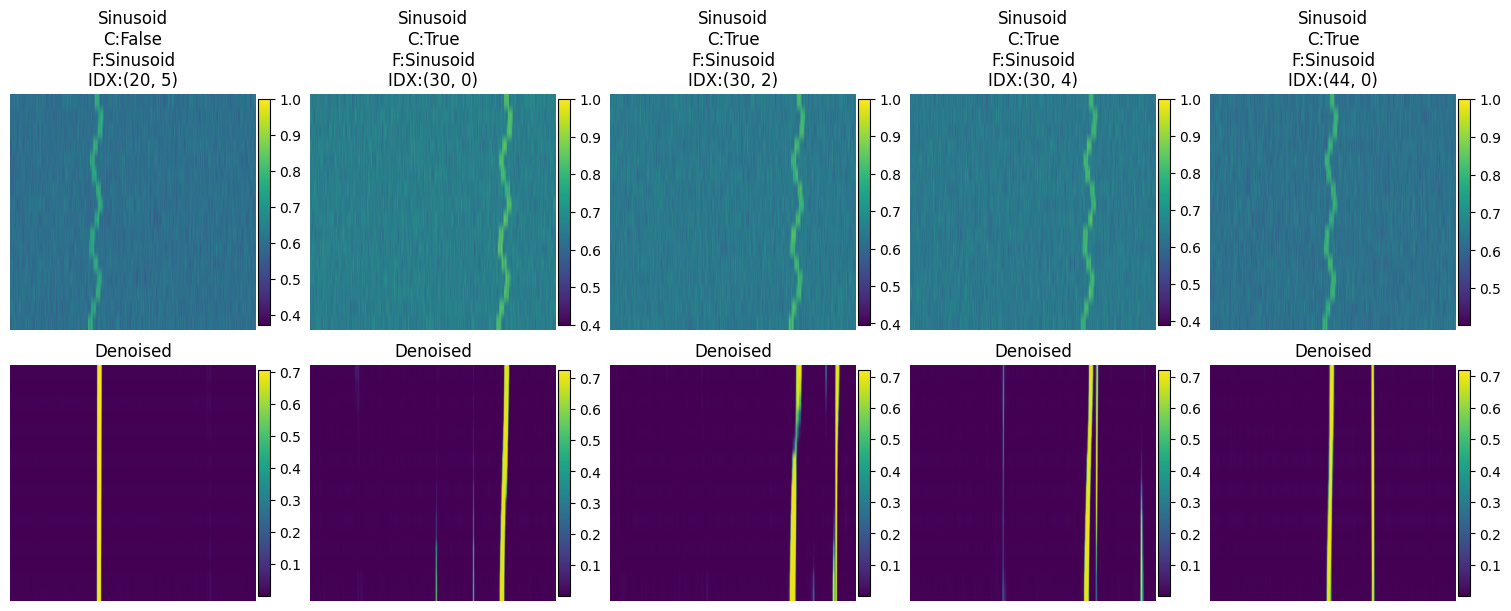

In [ ]:
# Pick first N Welsh_dragon samples from the *test* set and visualize
num_images = 5
indices_to_show = np.where(y_test[:, 2] == "Sinusoid")[0].tolist()
indices_to_show = indices_to_show[5:5 + num_images]  # skip first few, take next num_images

# Stack the *noisy* frames from the dataset
sample_data  = torch.stack([test_dataset[i][0] for i in indices_to_show]).to(device, non_blocking=True)
sample_labels = [y_test[i] for i in indices_to_show]

model.eval()
with torch.no_grad():
    reconstructed = model(sample_data)  # DAE: just the reconstruction

# Plot
fig, axes = plt.subplots(2, num_images, figsize=(3 * num_images, 6), constrained_layout=True)
for col, i_ds in enumerate(indices_to_show):
    inj_type, cadence_label, frame_flag, orig_idx = sample_labels[col]

    ax0 = axes[0, col]
    im0 = ax0.imshow(sample_data[col, 0].detach().cpu().numpy(), aspect='auto', cmap='viridis')
    ax0.set_title(f"{inj_type}\nC:{cadence_label}\nF:{frame_flag}\nIDX:{orig_idx}")
    ax0.axis("off")
    plt.colorbar(im0, ax=ax0, fraction=0.046, pad=0.01)

    ax1 = axes[1, col]
    im1 = ax1.imshow(reconstructed[col, 0].detach().cpu().numpy(), aspect='auto', cmap='viridis')
    ax1.set_title("Denoised")
    ax1.axis("off")
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.01)

plt.show()


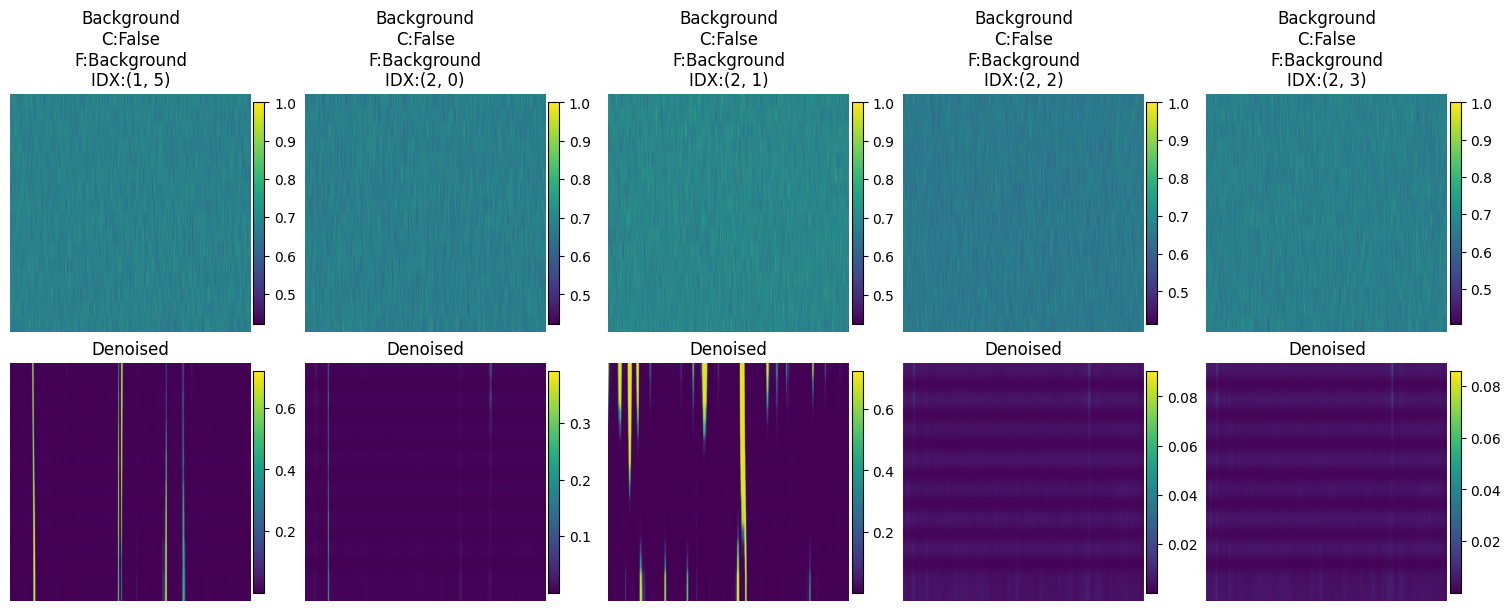

In [ ]:
# Pick first N Welsh_dragon samples from the *test* set and visualize
num_images = 5
indices_to_show = np.where(y_test[:, 2] == "Background")[0].tolist()
indices_to_show = indices_to_show[5:5 + num_images]  # skip first few, take next num_images

# Stack the *noisy* frames from the dataset
sample_data  = torch.stack([test_dataset[i][0] for i in indices_to_show]).to(device, non_blocking=True)
sample_labels = [y_test[i] for i in indices_to_show]

model.eval()
with torch.no_grad():
    reconstructed = model(sample_data)  # DAE: just the reconstruction

# Plot
fig, axes = plt.subplots(2, num_images, figsize=(3 * num_images, 6), constrained_layout=True)
for col, i_ds in enumerate(indices_to_show):
    inj_type, cadence_label, frame_flag, orig_idx = sample_labels[col]

    ax0 = axes[0, col]
    im0 = ax0.imshow(sample_data[col, 0].detach().cpu().numpy(), aspect='auto', cmap='viridis')
    ax0.set_title(f"{inj_type}\nC:{cadence_label}\nF:{frame_flag}\nIDX:{orig_idx}")
    ax0.axis("off")
    plt.colorbar(im0, ax=ax0, fraction=0.046, pad=0.01)

    ax1 = axes[1, col]
    im1 = ax1.imshow(reconstructed[col, 0].detach().cpu().numpy(), aspect='auto', cmap='viridis')
    ax1.set_title("Denoised")
    ax1.axis("off")
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.01)

plt.show()


Encoding test set:   0%|          | 0/204 [00:00<?, ?it/s]

/tmp/ipykernel_1874273/227278286.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10", len(unique_tags))


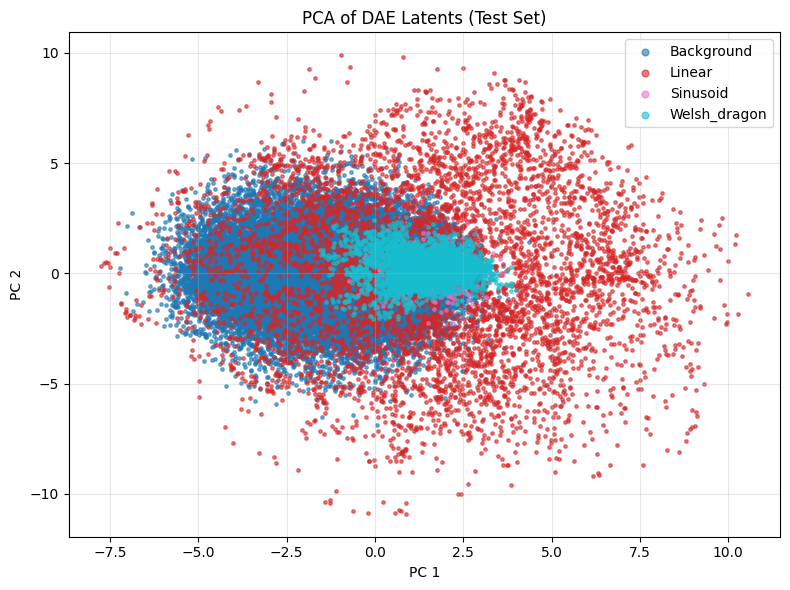

In [ ]:
from sklearn.decomposition import PCA


# 1) Encode all test samples to latent z
model.eval()
latents = []
with torch.no_grad():
    for noisy, _, _ in tqdm(testloader, desc="Encoding test set"):
        noisy = noisy.to(device, non_blocking=True)
        z = model.encode(noisy)       # (B, latent_dim)
        latents.append(z.cpu())
all_latents = torch.cat(latents, dim=0).numpy()  # (N_test, latent_dim)

# 2) Collect frame tags from y_test (3rd element is frame_flag)
frame_tags = np.array([lab[2] for lab in y_test])

# 3) PCA → 2D
latent_2d = PCA(n_components=2).fit_transform(all_latents)

# 4) Scatter by tag
unique_tags = np.unique(frame_tags)
cmap = plt.cm.get_cmap("tab10", len(unique_tags))

plt.figure(figsize=(8, 6))
for idx, tag in enumerate(unique_tags):
    mask = frame_tags == tag
    plt.scatter(latent_2d[mask, 0], latent_2d[mask, 1],
                s=6, alpha=0.6, color=cmap(idx), label=str(tag))
plt.title("PCA of DAE Latents (Test Set)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(markerscale=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


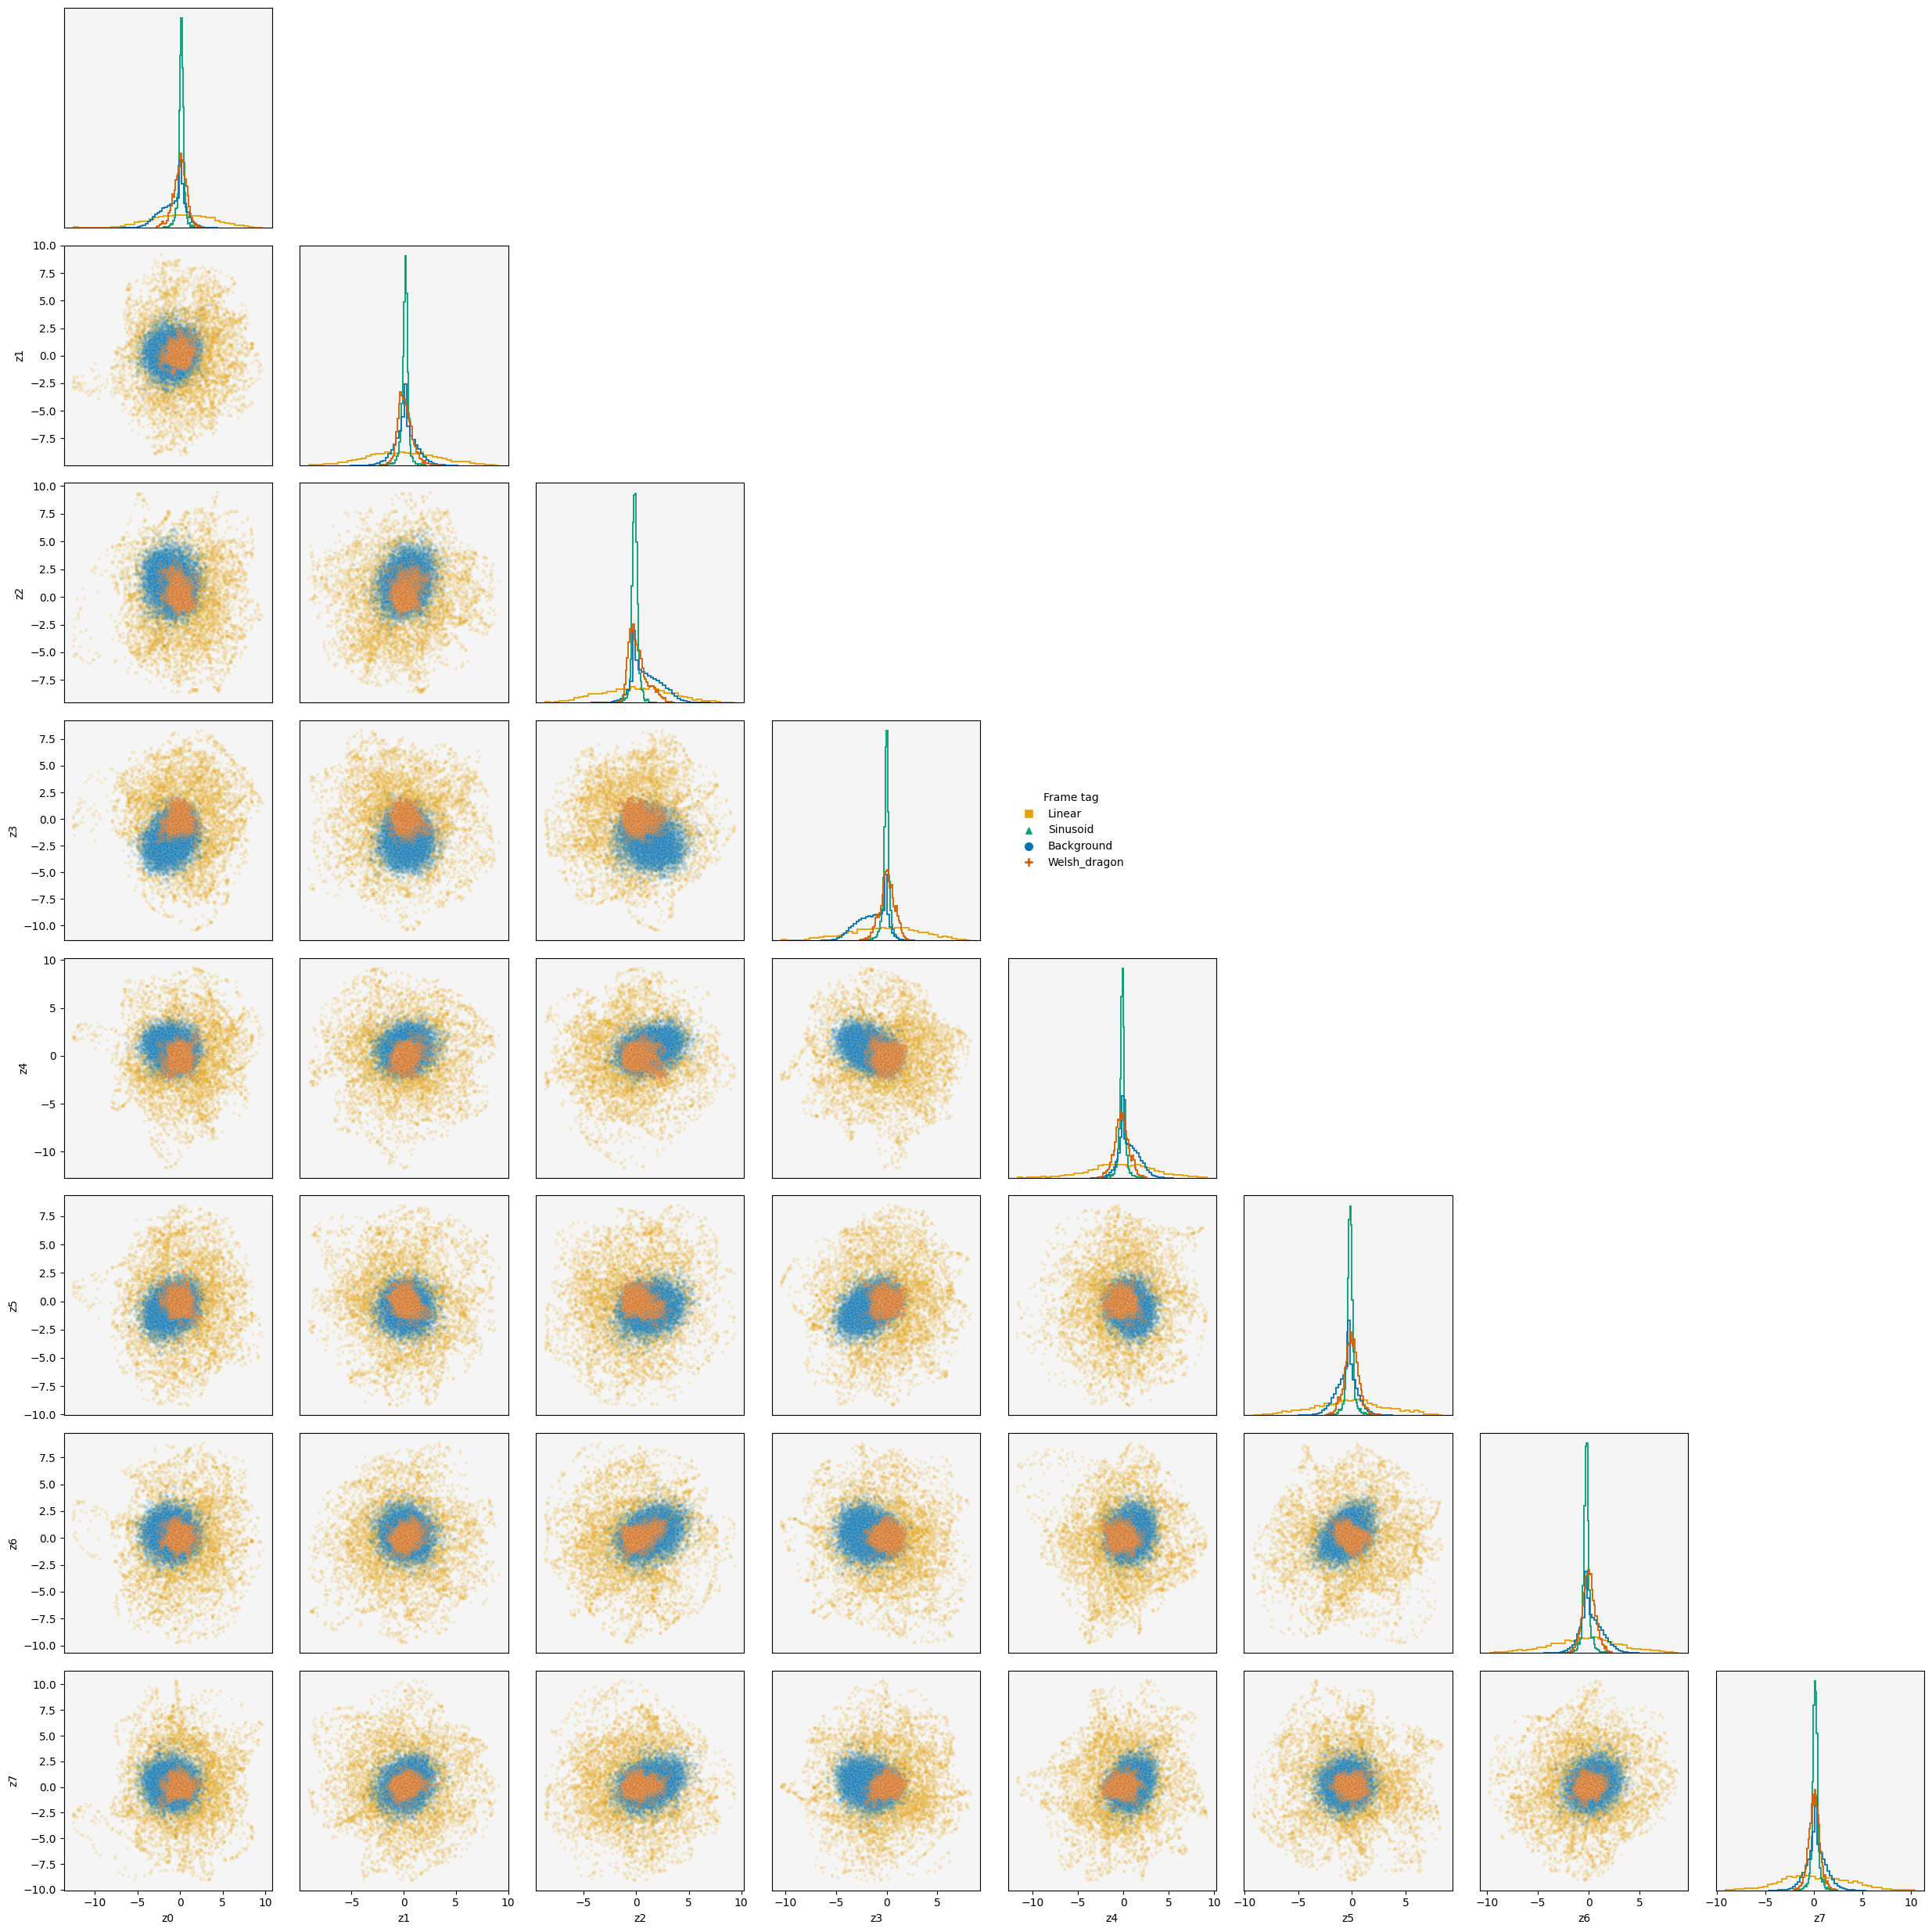

In [ ]:
# ╔════════════ Scatter-matrix (blue/green CVD-safe; Background on top) ═══════════╗

from matplotlib.lines import Line2D

# ── 1. Data ➝ NumPy ───────────────────────────────────────────────────────────
Z = (all_latents.detach().cpu().numpy()
     if torch.is_tensor(all_latents) else np.asarray(all_latents))
tags = np.asarray(frame_tags)

_, n_dims = Z.shape
dim_labels = [f"z{i}" for i in range(n_dims)]

# ── 2. Okabe–Ito palette & shapes ─────────────────────────────────────────────
colour_map = {
    "Background"   : "#0072B2",   # blue  (CVD-safe)
    "Linear"       : "#E69F00",   # orange
    "Sinusoid"     : "#009E73",   # green (CVD-safe vs blue)
    "Welsh_dragon" : "#D55E00",   # vermillion
}
marker_map = {
    "Background"   : "o",
    "Linear"       : "s",
    "Sinusoid"     : "^",
    "Welsh_dragon" : "P",
}

def c(tag): return colour_map.get(tag, "#666666")
def m(tag): return marker_map.get(tag, "o")

unique_tags = np.unique(tags)

# ── 3. Sub-sampling parameters ────────────────────────────────────────────────
plot_sample  = 10_000
subsamp_tags = {"Background", "Linear", "Sinusoid", "Welsh_dragon"}

# ── 4. Explicit draw order: Linear → Sinusoid → Background → Welsh_dragon ────
tag_order = ["Linear", "Sinusoid", "Background", "Welsh_dragon"]
tag_order = [t for t in tag_order if t in unique_tags]  # keep existing only

# ── 5. Figure & grid ─────────────────────────────────────────────────────────
fig, axes = plt.subplots(
    n_dims, n_dims,
    figsize=(3.1 * n_dims, 3.1 * n_dims),
    subplot_kw={'facecolor': 'whitesmoke'}
)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# ── 6. Plot loop ─────────────────────────────────────────────────────────────
for i in range(n_dims):
    for j in range(n_dims):
        ax = axes[i, j]

        # Diagonal: probability-density histograms
        if i == j:
            for tag in tag_order:
                mask = tags == tag
                data_i = Z[mask, i]

                # if tag == "Background":
                #     # manual histogram → scale heights by 0.001
                #     heights, bins = np.histogram(data_i, bins=40, density=True)
                #     heights *= 0.01
                #     bin_centres = 0.5*(bins[:-1] + bins[1:])
                #     ax.step(
                #         bin_centres, heights,
                #         where='mid',
                #         color=c(tag),
                #         linewidth=1.3
                #     )
                # else:
                ax.hist(
                    data_i,
                    bins=40,
                    density=True,
                    histtype='step',
                    color=c(tag),
                    linewidth=1.3
                )

            ax.set_ylabel('')
            ax.set_yticks([])

        # Lower-triangle: scatter panels
        elif i > j:
            for tag in tag_order:
                mask = tags == tag

                if tag in subsamp_tags and mask.sum() > plot_sample:
                    keep = np.random.choice(np.where(mask)[0], plot_sample, replace=False)
                    mask = np.zeros_like(mask, dtype=bool); mask[keep] = True

                ax.scatter(
                    Z[mask, j], Z[mask, i],
                    s       = 10 if tag in subsamp_tags else 20,
                    alpha   = 0.15 if tag in subsamp_tags else 0.5,
                    color   = c(tag),
                    marker  = m(tag),
                    edgecolors='white', linewidths=0.25,
                    zorder  = {"Linear":2, "Sinusoid":2,
                               "Background":2, "Welsh_dragon":2}.get(tag, 3)
                )
        else:
            ax.axis('off')

        # Labels on outer edge only
        if i == n_dims - 1 and j <= i:
            ax.set_xlabel(dim_labels[j])
        else:
            ax.set_xticks([])
        if j == 0 and i != 0:
            ax.set_ylabel(dim_labels[i])
        else:
            ax.set_yticks([])

# ── 7. Legend over z4 / right of z3 ──────────────────────────────────────────
legend_row, legend_col = 3, 4
if legend_row >= n_dims or legend_col >= n_dims:
    legend_row, legend_col = 0, n_dims - 1
legend_ax = axes[legend_row, legend_col]
legend_ax.axis('off')

handles = [
    Line2D([], [], linestyle='', marker=m(tag), markersize=9,
           markeredgecolor='white', color=c(tag), label=tag)
    for tag in tag_order
]
legend_ax.legend(
    handles=handles, title='Frame tag',
    loc='center left', bbox_to_anchor=(0.0, 0.5), frameon=False
)

plt.tight_layout()
plt.savefig("Output_corner_forNAM_2.pdf")
plt.show()

In [ ]:
# ╔════════════ Corner of Fourier-transformed densities (latent space) ═══════════╗
# What it does
# - For each dim z_i: builds a 1D density (hist, density=True), FFT → |spectrum|
# - For each pair (z_j, z_i): builds a 2D density on a common grid, FFT2 → |spectrum|
# - Plots a corner matrix: diagonal = 1D |FFT| curves; lower triangle = 2D |FFT| contours
# - Colours/tags match your original plot


# ── 0. Data in numpy ────────────────────────────────────────────────────────────
Z_in  = all_latents if 'all_latents' in globals() else Z   # accepts either name
Z     = (Z_in.detach().cpu().numpy() if torch.is_tensor(Z_in) else np.asarray(Z_in))
tags  = np.asarray(frame_tags)

N, n_dims = Z.shape
dim_labels = [f"z{i}" for i in range(n_dims)]

# ── 1. Palette / markers (Okabe–Ito like your plot) ────────────────────────────
colour_map = {
    "Background"   : "#0072B2",   # blue
    "Linear"       : "#E69F00",   # orange
    "Sinusoid"     : "#009E73",   # green
    "Welsh_dragon" : "#D55E00",   # vermillion
}
marker_map = {"Background":"o","Linear":"s","Sinusoid":"^","Welsh_dragon":"P"}
def C(tag): return colour_map.get(tag, "#666666")

unique_tags = [t for t in ["Linear","Sinusoid","Background","Welsh_dragon"]
               if t in np.unique(tags)]

# ── 2. Common histogram grids (important so spectra are comparable) ────────────
# 1D grids per dimension
one_d_bins = 256
ranges_1d = []
for i in range(n_dims):
    lo, hi = np.percentile(Z[:, i], [0.1, 99.9])
    pad = 0.05*(hi-lo) + 1e-9
    ranges_1d.append((lo-pad, hi+pad))

# 2D grids per pair
two_d_bins = 128  # balance resolution vs speed/memory
ranges_2d = {}
for i in range(1, n_dims):
    for j in range(i):
        ranges_2d[(i,j)] = (ranges_1d[j], ranges_1d[i])

# ── 3. FFT helpers ──────────────────────────────────────────────────────────────
def fft_mag_1d(density):
    S = np.fft.fftshift(np.fft.fft(density))
    return np.abs(S)

def fft_mag_2d(density2d):
    S = np.fft.fftshift(np.fft.fft2(density2d))
    return np.abs(S)

def normalise(img):
    m = np.max(img)
    return img/m if m > 0 else img

# frequencies (index units; just label as k)
freq_1d = np.fft.fftshift(np.fft.fftfreq(one_d_bins))  # unitless “k”
freq_2d = np.fft.fftshift(np.fft.fftfreq(two_d_bins))
KX, KY = np.meshgrid(freq_2d, freq_2d)

# ── 4. Precompute per-tag spectra ──────────────────────────────────────────────
spectra_1d = {tag: [] for tag in unique_tags}
for tag in unique_tags:
    mask = tags == tag
    X = Z[mask]

    for i in range(n_dims):
        hist, edges = np.histogram(X[:, i], bins=one_d_bins, range=ranges_1d[i], density=True)
        S = fft_mag_1d(hist.astype(np.float64))
        spectra_1d[tag].append(normalise(np.log1p(S)))  # log for dynamic range

spectra_2d = {tag: {} for tag in unique_tags}
for tag in unique_tags:
    mask = tags == tag
    X = Z[mask]
    for i in range(1, n_dims):
        for j in range(i):
            (xlo,xhi), (ylo,yhi) = ranges_2d[(i,j)]
            H, xedges, yedges = np.histogram2d(
                X[:, j], X[:, i],
                bins=two_d_bins,
                range=[[xlo,xhi],[ylo,yhi]],
                density=True
            )
            S2 = fft_mag_2d(H.astype(np.float64))
            spectra_2d[tag][(i,j)] = normalise(np.log1p(S2))

# ── 5. Plot (corner layout like before) ────────────────────────────────────────
fig, axes = plt.subplots(
    n_dims, n_dims,
    figsize=(3.1*n_dims, 3.1*n_dims),
    subplot_kw={'facecolor': 'whitesmoke'}
)
plt.subplots_adjust(wspace=0.05, hspace=0.05)

for i in range(n_dims):
    for j in range(n_dims):
        ax = axes[i, j]

        if i == j:
            # Diagonal: overlay 1D |FFT| curves (log-scaled & normalised)
            for tag in unique_tags:
                S = spectra_1d[tag][i]
                ax.plot(freq_1d, S, lw=1.2, color=C(tag), label=tag, alpha=0.95)
            ax.set_xlim(freq_1d.min(), freq_1d.max())
            ax.set_yticks([])

        elif i > j:
            # Lower triangle: overlay a few contour levels of the 2D |FFT| per tag
            levels = [0.4, 0.6, 0.8]  # relative levels after normalise(log1p(.))
            for tag in unique_tags:
                S2 = spectra_2d[tag][(i,j)]
                ax.contour(
                    KX, KY, S2,
                    levels=levels,
                    colors=[C(tag)],
                    linewidths=0.9,
                    alpha=0.85
                )
            ax.set_xlim(freq_2d.min(), freq_2d.max())
            ax.set_ylim(freq_2d.min(), freq_2d.max())
        else:
            ax.axis('off')

        # tidy labels like your original
        if i == n_dims - 1 and j <= i:
            ax.set_xlabel(f"k({dim_labels[j]})")
        else:
            ax.set_xticks([])
        if j == 0 and i != 0:
            ax.set_ylabel(f"k({dim_labels[i]})")
        else:
            ax.set_yticks([])

# Legend panel
legend_row, legend_col = min(3, n_dims-1), min(4, n_dims-1)
legend_ax = axes[legend_row, legend_col]
legend_ax.axis('off')
handles = [Line2D([], [], linestyle='-', color=C(tag), label=tag) for tag in unique_tags]
legend_ax.legend(handles=handles, title='Frame tag (Fourier domain)',
                 loc='center left', bbox_to_anchor=(0.0, 0.5), frameon=False)

plt.tight_layout()
plt.savefig("Corner_Fourier_latent.pdf", bbox_inches='tight')
plt.show()
# ╚══════════════════════════════════════════════════════════════════════════════╝


NameError: name 'Z' is not defined